# Sutton 책 Example 4.3 Gambler's Problem

### 질문

- Final policy 가 왜 이렇게 나올까?

### 목표

- Policy iteration / Value iteration 구현
    - PI(iteration=1) == VI() ?
- Final policy 체크

## Policy Iteration

<img src=PI.png width=80%/>

# Value Iteration

<img src=VI.png/ width=80%>

## PI vs VI

PI(iteration=1) == VI() ?

- PI 의 policy evaluation 부분과 VI 를 비교해보자. 거의 동일한데, VI 에서는 V(s) 를 업데이트 할 때 $\max_a$ 가 추가로 붙는다.
- PI(iteration=1) 세팅이라면:
    - 한 번 evaluation 을 하고, improvement 에서는 그 value 를 기반으로 greedy policy 로 폴리시를 업데이트한다. 
    - 그리고 다음 evaluation 때는 그 폴리시, 즉 이전 evaluation 에서 구한 value 에 대한 greedy policy 를 기반으로 value 를 다시 업데이트한다.
    - 이걸 하나로 합쳐보자. 이전 value 가 있다면, 이 value 에 대한 greedy policy 를 기반으로 value 를 업데이트하면 된다.
    - 그게 바로 VI.
    
즉 같다!

## Gambler problem

- Setting: 
    - States: 0~100 (0: lose, 100: win)
    - value(s) = expected winning probability
    - policy(s) = stake probabilities for state s
        - state s 에서 베팅할 수 있는 stake 들에 대한 확률들
    - trans_prob: 0.4 (head), 0.6 (tail)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def max_stake(state):
    # return maximum stake for current state
    # action in {0, 1, ... min(s, 100-s)}
    return min(state, 100-state)

In [3]:
# action 은 0부터 있지만, 0은 의미가 없음 (현재 상태 그대로)
# 빠른 수렴을 위해 1부터 사용. 0부터 해도 됨.
def get_actions(state):
    amax = max_stake(state)
    return list(range(1, amax+1))

In [4]:
def reward(state):
    if state == 100:
        return 1.
    return 0.

In [5]:
def next_states_with_probs(state, action):
    """
    현재 상태와 액션 그리고 transition probabilities 에 따른 다음 상태와 확률
    transition probabilities: p_h = 0.4 (p_t = 0.6)
    """
    
    assert state-action >= 0 and state+action <= 100
    
    return [(state+action, 0.4), (state-action, 0.6)]

In [6]:
def all_argmax(vector):
    m = np.max(vector)
    all_maxes = np.argwhere(vector == m)
    return all_maxes.flatten().tolist()

In [7]:
states = list(range(0, 101))
discount = 1.

class PolicyIteration(object):
    def __init__(self):
        self.value = np.zeros(101)
        self.policy = np.zeros([101, 101])
        self.policy_stable = False

        # init policy: random policy
        for state in states:
            # action in 0~min(s, 100-s)
            amax = max_stake(state)
            self.policy[state, :amax+1] = 1./(amax+1)

    def policy_evaluation(self, iteration=-1, theta=0.0001):
        """ 주어진 policy 를 evaluate 
        Args:
            iteration: 반복 횟수; -1이면 converge 할 때까지
            theta: minimum of delta; delta 가 theta 보다 작아지면 스톱 (converge 로 본다)
        Return:
            Next value function (value table)
        """

        i = 0
        delta = 0.
        # pseudo code 에서는 value 에 바로 업데이트를 하지만 분리하는게 좋을 듯
        cur_value = self.value.copy()
        next_value = np.zeros_like(self.value)
        while True:
            delta = 0
            for state in states[:-1]: # except terminal state
                # next_state: 현재 state 에서 폴리시를 따르는 경우 가는 다음 스테이트
                # discount factor = 1. (no discount)
                actions = get_actions(state)
                cur_state_value = 0.
                for stake in actions:
                    pi = self.policy[state, stake]
                    next_states = next_states_with_probs(state, stake)
                    for next_state, trans_prob in next_states:
                        # action(stake) 을 취해서 next_state 로 trans_prob 확률로 감.
                        # 이때의 expected value.
                        expected_value_by_action = reward(next_state) + discount*cur_value[next_state]
                        cur_state_value += pi * trans_prob * expected_value_by_action

                next_value[state] = cur_state_value
                cur_delta = abs(next_value[state] - cur_value[state])
                if delta < cur_delta:
                    delta = cur_delta
            
            i += 1
            if (delta < theta) or (i == iteration):
                break

            cur_value = next_value.copy()


        assert next_value[-1] == 0. # value of terminal state should be 0.

        self.value = next_value
    
    def policy_improvement(self):
        """ 
        계산한 value function (for current policy) 을 기반으로
        각 상태에서 value function 에 대해 greedy action 을 취하는 policy 로 update

        Return:
            New policy, policy_stable
            만약 stable 하면 종료 가능.
        """
        self.policy_stable = True
        new_policy = np.zeros_like(self.policy)
        
        # Q_list 는 디버깅 용으로 저장
        self.Q_list = np.zeros([101, 101])

        for state in states[1:-1]:
            actions = get_actions(state)
            """ policy evaluation 할 때 action 에 대해 loop 를 도는 것은
            policy 에 대해 value 를 expectation 하기 위함이지만,
            여기서는 각 action 을 선택했을 때의 greedy value q(s,a)를 구하기 위함임.
            """
            amax = np.max(actions)
            Q = np.zeros(amax+1)
            for stake in actions:
                next_states = next_states_with_probs(state, stake)
                expected_value_by_action = 0.
                for next_state, trans_prob in next_states:
                    expected_value_by_action += trans_prob * (reward(next_state) + discount*self.value[next_state])
                
                Q[stake] = expected_value_by_action

            max_Q = np.max(Q)
            max_cnt = np.sum(np.abs(Q - max_Q) < 1e-6)
            prob = 1. / max_cnt
            self.Q_list[state, :amax+1] = Q

            new_policy[state, :amax+1] = np.where(np.abs(Q - max_Q) < 1e-6, prob, 0.)

            # policy 의 sum 이 1이어야 함
            assert np.abs(np.sum(new_policy[state]) - 1.) < 1e-6

            # 아직 stable 이면 여전히 stable 인지 검사
            if self.policy_stable:
                org_maxes = all_argmax(self.policy[state])
                new_maxes = all_argmax(new_policy[state])
                self.policy_stable = org_maxes == new_maxes

        self.policy = new_policy

In [8]:
def show_PI_plot(sweep):
    print "sweep", sweep
    # value
    plt.plot(PI.value[:-1])
    plt.title("value")
    plt.show()
    
    # policy
    maxes = PI.policy[1:-1].max(axis=1).reshape(-1, 1)
    x, y = np.argwhere(PI.policy[1:-1] == maxes).T
    plt.plot(x, y, 'o', ms=3)
    plt.title("policy")
    plt.show()
    print "=========================================================================="

sweep 0


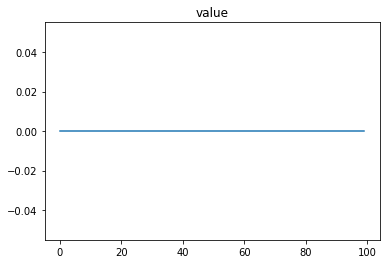

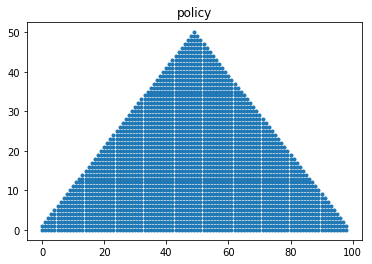

sweep 1


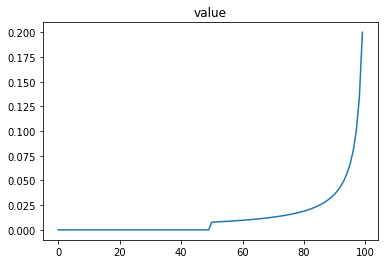

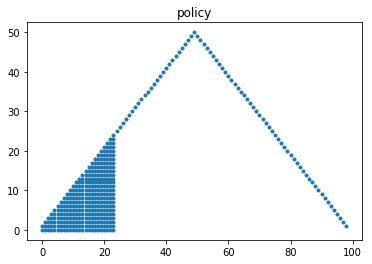

sweep 2


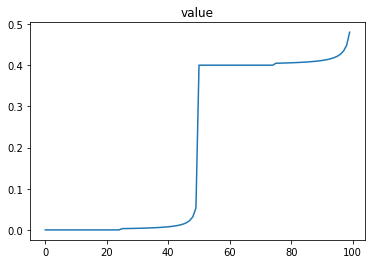

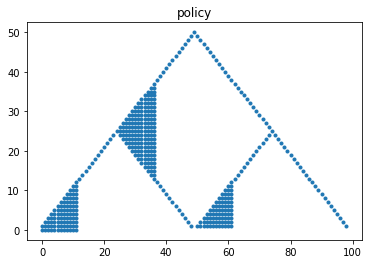

sweep 3


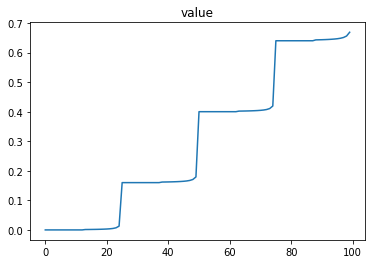

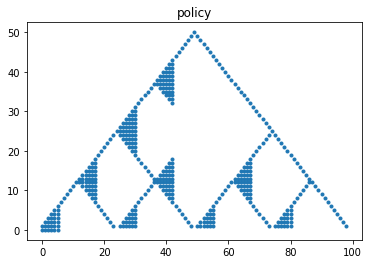

sweep 4


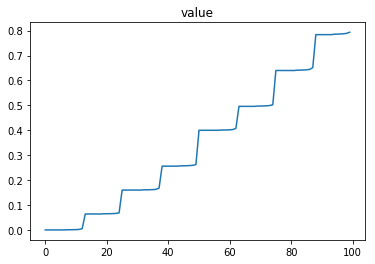

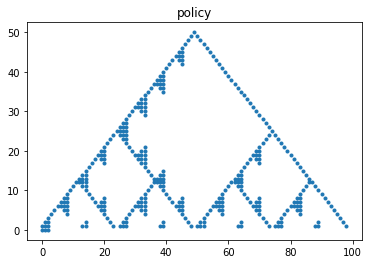

sweep 5


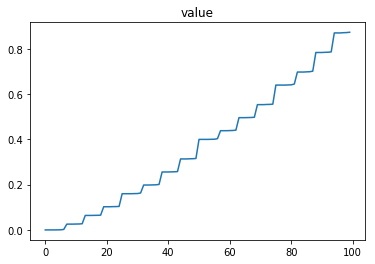

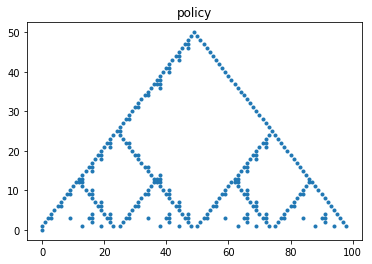

sweep 6


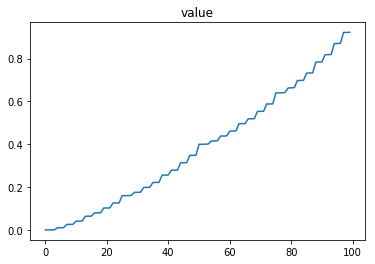

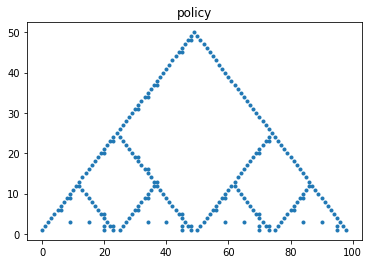

sweep 7


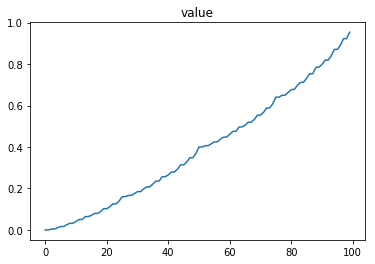

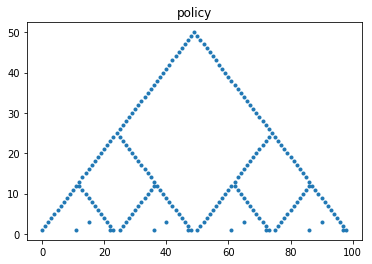

sweep 8


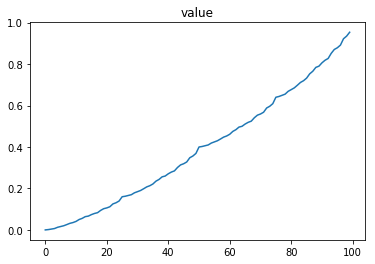

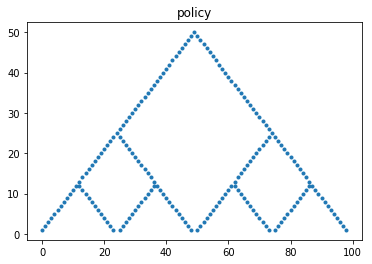

sweep 9


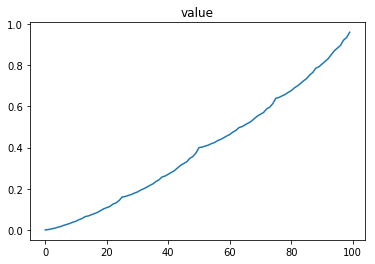

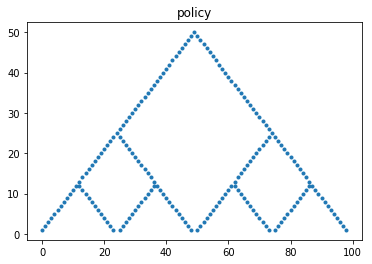

This is stable policy !


In [9]:
i = 1

PI = PolicyIteration()

show_PI_plot(0)

while True:
    PI.policy_evaluation(iteration=1)
    PI.policy_improvement()
    
    show_PI_plot(i)
    
    i += 1
    if PI.policy_stable:
        print("This is stable policy !")
        break